In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import loggamma

In [3]:
df = pd.read_csv('SLS22.csv')

# 1 Uppvärmning. 
Följande uppgifter bör göra dig bekant med datamängden och förbereda data för användning när du bygger dina prediktiva modeller.

(a) Alla betyg i dataramen är för närvarande tal mellan 0 och 10. Normalisera dessa värden i dataramen så att de är mellan 0 och 1.

In [4]:
for col in df.columns:
    if df[col].dtype == np.float64:
        df[col] = df[col].apply(lambda x: x/10)

(b) Gör ett histogram för alla trickbetyg för trick 1−4. Vad observerar du? Finns det ett visst värde som dyker upp oftare än de andra? Om så är fallet, hur står detta värde i jämförelse med de andra?

<Axes: ylabel='Frequency'>

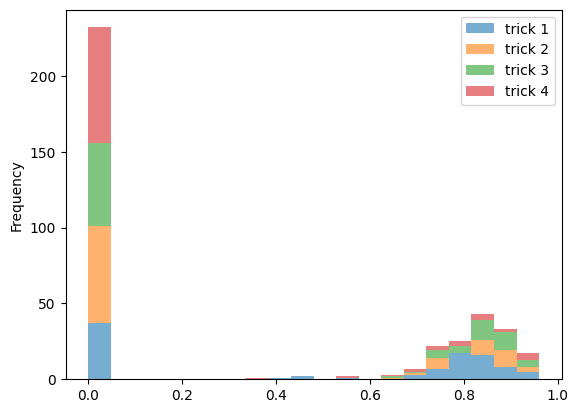

In [5]:
df[['trick 1', 'trick 2', 'trick 3', 'trick 4']].plot.hist(bins=20, stacked=True, alpha=0.6)

Svar: Det är tydligt att det absolut vanligaste talet är 0, dvs. att åkaren ej klarar trickcet.

(c) For varje trick 1−4 skapa en ny kolumn med namnet ’make i’ för i = 1, 2, 3, 4 så att värdet av ’make i’ i en given rad är 1 om skateboardåkaren landade trick i och 0 annars.

In [6]:
for i in range(1, 5):
    df[f"make {i}"] = df[f"trick {i}"].apply(lambda x: 1 if x > 0 else 0)

(d) För varje skateboardåkare skatta sannolikheten att ett trick får ett betyg som är större än 0.6 givet att skateboardåkaren landar tricket. Vad är sanno- likheten att skateboardåkaren inte lyckas landa ett visst trick? Vad observerar du? Relatera dina observationer till era observationer i del (b).

In [7]:
def compute_theta(group):
    total_tricks = 4 * len(group)
    passed_tricks = sum(group[f'make {i}'].sum() for i in range(1, 5))
    return pd.Series([total_tricks, passed_tricks, passed_tricks / total_tricks], index=['total', 'passed', 'theta'])

df_theta = df.groupby('id').apply(compute_theta).reset_index()
print(df_theta)

           id  total  passed     theta
0      Berger   12.0     2.0  0.166667
1     Decenzo   16.0     7.0  0.437500
2       Eaton    8.0     5.0  0.625000
3         Foy   12.0     6.0  0.500000
4        Fynn   12.0     6.0  0.500000
5     Gustavo   20.0     8.0  0.400000
6       Hoban   20.0     8.0  0.400000
7     Hoefler   16.0     7.0  0.437500
8    Horigome   16.0     9.0  0.562500
9      Huston    8.0     3.0  0.375000
10     Jordan   20.0     8.0  0.400000
11     Joslin   20.0     9.0  0.450000
12    Majerus    8.0     3.0  0.375000
13    McClung    4.0     1.0  0.250000
14     Midler   12.0     4.0  0.333333
15      Milou   20.0     9.0  0.450000
16       Mota   12.0     3.0  0.250000
17   Oliveira   12.0     5.0  0.416667
18    O’neill   12.0     3.0  0.250000
19       Papa   16.0     7.0  0.437500
20    Pudwill   12.0     3.0  0.250000
21  Ribeiro C   12.0     3.0  0.250000
22  Ribeiro G   24.0    13.0  0.541667
23  Rodriguez    8.0     4.0  0.500000
24   Santiago   12.0     

Svar: Om en skateboardare klarar tricket så får de nästan alltid ett betyg över 0.6. Detta ser man också i histogrammen.

(e) Gör ett spridningsdiagram för runbetyg 1 mot runbetyg 2. Ser du någon tydligt korrelation från diagrammet?

0.19053845069841102


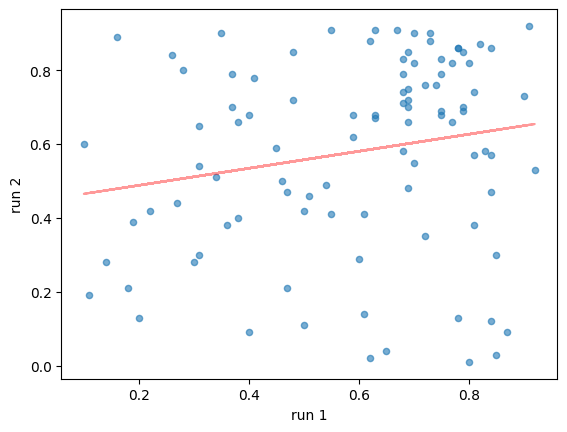

In [8]:
df.plot.scatter(x='run 1', y='run 2', alpha=0.6)
z = np.polyfit(df['run 1'], df['run 2'], 1)
p = np.poly1d(z)
ro = np.corrcoef(df['run 1'], df['run 2'])[0, 1]
plt.plot(df['run 1'],p(df['run 1']),"r-", alpha=0.4)
print(ro)
plt.show()

Svar: Väldigt svag positiv korrerlation, ro=0.19. Många värden verkar vara koncentrerade i övre högra hörnet, men annars är spridningen väldigt stor.

# 2. En frekventistisk modell.

(a) Ge en punktskattning för varje θi, sannolikheten att skateboardåkaren i landar ett trick.
θi = x_bar, dvs. theta från ovan

(b) Ge en punktskattning för parametrarna [αi,βi]T för varje skateboardåkare i. Finns det skateboardåkare för vilka din valda punktskattning inte existera? I så fall föreslå en alternativ punktskattning för dessa αi, βi. Motivera dina val punktskattningar.

In [9]:
def estimate_alpha_beta(scores):
    mean = scores.mean()
    var = scores.var()
    alpha = mean * (mean * (1 - mean) / var - 1)
    beta = (1 - mean) * (mean * (1 - mean) / var - 1)
    return alpha, beta

In [10]:
drop_cols = ["Horigome", "Joslin", "Milou", "Ribeiro G"]
gdf = df[~df["id"].isin(drop_cols)].groupby('id')

In [11]:
def compute_stats(group):
    total_tricks = 4 * len(group)
    passed_tricks = sum(group[f'make {i}'].sum() for i in range(1, 5))
    
    trick_scores = np.concatenate([group.loc[group[f'make {i}'] == 1, f'trick {i}'] for i in range(1, 5)])
    run_scores = np.concatenate([group[f'run {i}'] for i in range(1, 3)])
    
    theta = passed_tricks / total_tricks
    alpha_trick, beta_trick = estimate_alpha_beta(trick_scores) if len(trick_scores) >= 2 else (1, 1)
    alpha_run, beta_run = estimate_alpha_beta(run_scores) if len(run_scores) >= 2 else (1, 1)
    
    return pd.Series(
        [theta, alpha_trick, beta_trick, alpha_run, beta_run], 
        index=['theta', 'alpha_trick', 'beta_trick', 'alpha_run', 'beta_run']
    )

freq_params = gdf.apply(compute_stats)
print(freq_params)

              theta  alpha_trick  beta_trick    alpha_run     beta_run
id                                                                    
Berger     0.166667   159.140000   58.860000     2.794278     4.591480
Decenzo    0.437500    24.455929    5.110825     4.164506     2.834664
Eaton      0.625000    75.408256   20.045233   103.573288    36.865068
Foy        0.500000    51.589516    9.104032     3.506609     4.088934
Fynn       0.500000    32.488000    6.812000     5.221980     5.582117
Gustavo    0.400000    70.644593   17.523386     1.228081     0.856946
Hoban      0.400000   107.698921   15.034892     3.632207     2.096826
Hoefler    0.437500    32.522583    9.403399     1.754494     0.965652
Huston     0.375000   142.310000   18.190000     6.328318     1.837254
Jordan     0.400000    23.062983    3.638010     3.608210     1.228533
Majerus    0.375000     2.912773    2.724852     1.755202     2.474200
McClung    0.250000     1.000000    1.000000  2585.790000  5892.210000
Midler

(d) Använd din modell för [Xi,Yi]T för att simulera 5000 LCQ:ar och för varje simulering extrahera de fyra skateboardåkare W = [W1,W2,W3,W4]^T med de högsta totalbetygen. Vad är typvärdet för W1, ... , W5000? De riktiga vinnarna för LCQ:en är Gustavo, Hoban, Eaton, Decenzo. Hur många av de riktiga vinnarna förutsägs av typvärdet? Vad är skattade sannolikheten för de riktiga vinnarna baserat på dina simuleringar? Av typvärdet?

In [12]:
results = []
for _ in range(5000):
    row_scores = {}
    for _, row in freq_params.iterrows():
        score = 0
        
        # runs
        alpha_tricks, beta_tricks = row[f'alpha_run'], row[f'beta_run']
        for _ in range(1, 3):
            score += np.random.beta(alpha_tricks, beta_tricks)
        
        # tricks
        alpha_tricks, beta_tricks = row[f'alpha_trick'], row[f'beta_trick']
        for _ in range(1, 5):
            if np.random.uniform() < row['theta']:
                score += np.random.beta(alpha_tricks, beta_tricks)
        row_scores[row.name] = score
    results.append(row_scores)
frequentist_scores_df = pd.DataFrame(results)

In [24]:
freq_total_scores = frequentist_scores_df.sum(axis=0)
freq_total_scores.sort_values(ascending=False, inplace=True)
print('Highest total scores')
print(freq_total_scores[0:4])

freq_top_4 = frequentist_scores_df.apply(lambda row: row.nlargest(4).index.tolist(), axis=1)
freq_top_4 = [item for sublist in freq_top_4 for item in sublist]
freq_top_4 = pd.Series(freq_top_4).value_counts()
print('\nMost frequent top 4')
print(freq_top_4[0:4])

# Probability that winners won. 
print('\nProbability that winners won')
winners = ['Gustavo', 'Hoban', 'Eaton', 'Decenzo']
for winner in winners:
    print(f"{winner}: {freq_top_4[winner] / len(frequentist_scores_df)}")

Highest total scores
Eaton     17199.291935
Suciu     16018.092300
Jordan    14430.581765
Huston    14421.925473
dtype: float64

Most frequent top 4
Eaton     2790
Suciu     2240
Jordan    1497
Huston    1491
Name: count, dtype: int64

Probability that winners won
Gustavo 0.1574
Hoban 0.219
Eaton 0.558
Decenzo 0.2168


# 3. En bayesiansk modell.

(a) Föreslå en simultan apriorifördelning för parametrarna [Θi , Ai , Bi ]T för Xi där vi antar Θi ⊥ Ai, Bi för alla i. Motivera ditt val.

$\Theta_{i} \perp\!\!\!\perp A_{i}, B_{i} \implies f_{\Theta_{i}, A_{i}, B_{i}}(\theta_{i}, \beta_{i}, \alpha_{i})=f_{\Theta_{i}}(\theta_{i}) f_{A_{i}, B_{i}}(\alpha_{i}, \beta_{i})$ och vi kan därmed behandla $\Theta_{i}$ och $A_{i}, B_{i}$ separat.

$Ber(\theta_{i})$ har som konjugerad apriorifördelning $Beta(a_{i}, b_{i})$, och vi kommer därmed använda den.

$Beta(\alpha_{i}, \beta_{i})$ har ingen konjugerad apriorifördelning, men med hjälp av samma knep som i Exempel 10.8 så kan vi få följande apriorifördelning:
$$
f_{A_{i}, B_{i}}(\alpha_{i}, \beta_{i}) = \frac{\lambda^{\phi_{i}}}{\Gamma(\phi_{i})} (\alpha_{i} + \beta_{i} + 1)^{\phi_{i} - 1} e^{-\lambda_{i}(\alpha_{i} + \beta_{i} + 1)} (\alpha_{i} + \beta_{i})^{-1}
$$
Sammansatt får vi följande funktion för den simultana apriorifördelningen:
$$
f_{\Theta_{i}, A_{i}, B_{i}}(\theta_{i}, \alpha_{i}, \beta_{i}) = (\frac{\Gamma(a_{i} + b_{i})}{\Gamma(a_{i}) \Gamma(b_{i})} \theta_{i}^{a_{i}-1} (1-\theta_{i})^{b_{i}-1}) (\frac{\lambda^{\phi_{i}}}{\Gamma(\phi_{i})} (\alpha_{i} + \beta_{i} + 1)^{\phi_{i} - 1} e^{-\lambda_{i}(\alpha_{i} + \beta_{i} + 1)} (\alpha_{i} + \beta_{i})^{-1})
$$
Vi kommer använda $a_{i}=b_{i}=1$, som val för en icke-informativ fördelning för $\Theta_{i}$. Vi väljer samma värden som i Exempel 10.8 för $A_{i}, B_{i}$, dvs $\lambda_{i}=1, \phi_{i}=3$.

(b) Generera 5000 slumpmässiga utfall från aposteriorifördelningen fθi,αi,βi|Xi (θi, αi, βi|xi).
Plotta dina resulterande utfall för de marginella aposteriorifördelningarna:
fθi|Xi (θi|xi) and fαi,βi|Xi (αi, βi|xi).
Beräkna det aposteriori stickprovsmedelvärdet och den aposteriori stickprov-
sorvariansen för varje parameter θi,αi, och βi för alla skateboardåkare.

Vi utnyttjar det faktum att $f_{\Theta | \mathbf{X}}(\theta | \mathbf{x}) \propto f_{\mathbf{X} | \Theta}(\mathbf{x} | \theta) f_{\Theta}(\theta)$ tillsammans med metropolisalgoritmen som har den trevliga egenskapen att $f$ ej måste vara normaliserad. 
#### du är inte klar här

In [14]:
def log_prior_trick(theta, alpha, beta, a = 1, b = 1, lamda = 1, phi = 3):
    return (a - 1) * np.log(theta) + (b - 1) * np.log(1 - theta) + (phi - 1) * np.log(alpha + beta + 1) - lamda*(alpha + beta + 1) - np.log(alpha + beta)

def log_posterior_trick(data, theta, alpha, beta, a = 1, b = 1, lamda = 1, phi = 3): # ignoring constants
    log_p = log_prior_trick(theta, alpha, beta, a, b, lamda, phi)
    
    for x in data:
        if x == 0:
            log_p += np.log(1 - theta)
        else:
            log_p += np.log(theta) + loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1) * np.log(x) + (beta - 1) * np.log(1 - x)

    return log_p
        

In [15]:
def metropolis_algorithm(data, log_posterior_func, n_samples, proposal_sd, start_params):
    # Initialize the chain with the starting parameters
    current_params = start_params
    current_log_posterior = log_posterior_func(data, *current_params)

    samples = np.empty((n_samples, len(start_params)))
    for i in range(n_samples):
        proposed_params = [np.exp(np.log(param) + proposal_sd[i] * np.random.normal(0, 1, 1)[0]) for i, param in enumerate(current_params)]
        if len(start_params) == 3:
            proposed_params[0] = np.clip(proposed_params[0], 1e-6, 1-1e-6)
        
        proposed_log_posterior = log_posterior_func(data, *proposed_params)

        acceptance_prob = min(1, np.exp(proposed_log_posterior - current_log_posterior))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            current_params = proposed_params
            current_log_posterior = proposed_log_posterior

        samples[i] = current_params

    return samples

In [16]:
n_chains = 4
n_samples = 6000
proposal_sd = [0.3, 0.3, 0.3]

trick_samples_dict = {}
for name, group in gdf:
    theta_start = np.linspace(0.05, 0.95, n_chains)
    alpha_start = freq_params.loc[name, 'alpha_trick'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    beta_start = freq_params.loc[name, 'beta_trick'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    
    tricks = np.concatenate([group[f'trick {i}'] for i in range(1, 5)])
    
    samples_list = []
    for i in range(n_chains):
        samples = metropolis_algorithm(tricks, log_posterior_trick, n_samples, proposal_sd, [theta_start[i], alpha_start[i], beta_start[i]])
        samples_list.append(samples)
    trick_samples_dict[name] = samples_list

/var/folders/q5/6vbw5t_91_l67h7nh6f4cqph0000gn/T/ipykernel_11665/32922667.py:14: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1, np.exp(proposed_log_posterior - current_log_posterior))


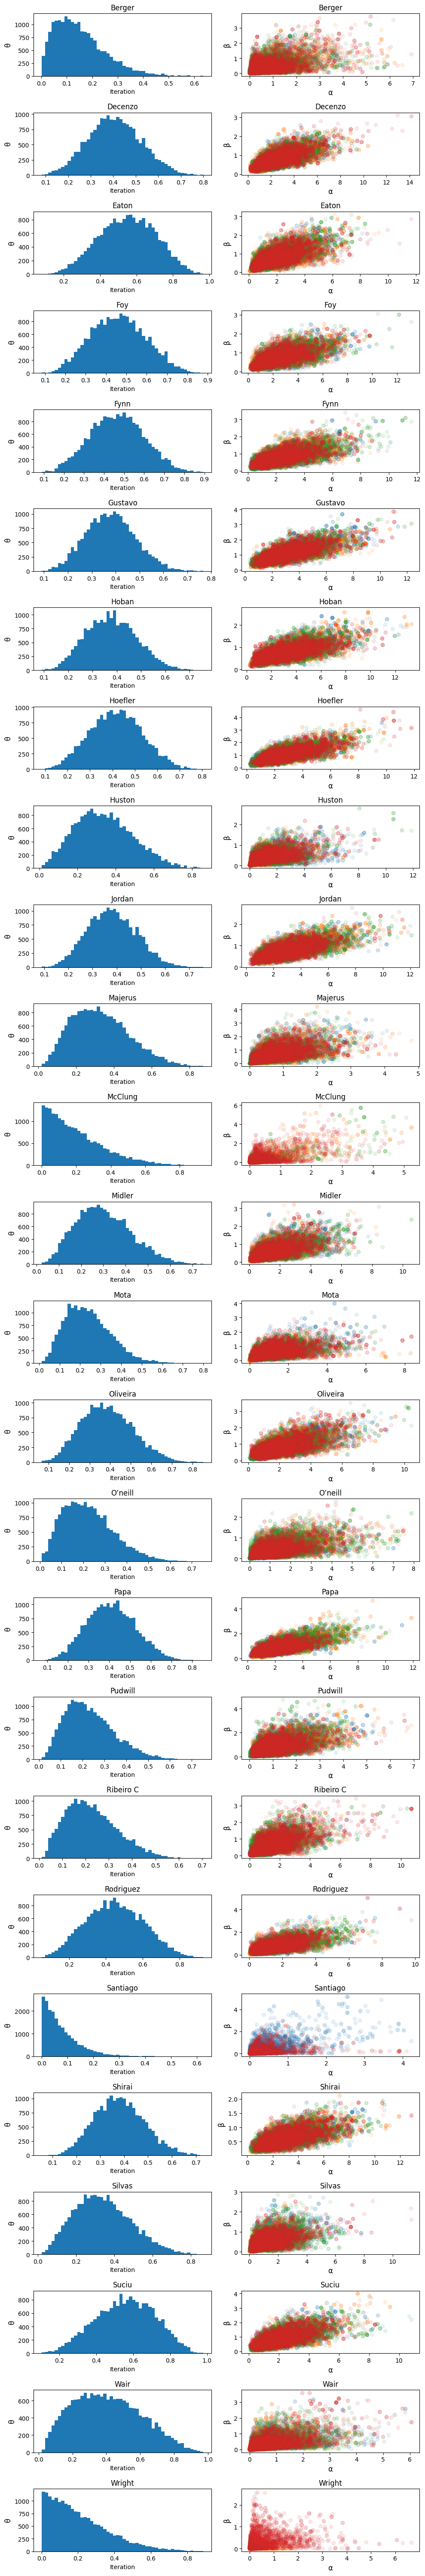

In [17]:
rows = len(trick_samples_dict)
fig, axs = plt.subplots(rows, 2, figsize=(10, 60))

# hist of theta, heatmap of alpha and beta
# ignore first 1000 samples
for row, (name, samples) in enumerate(trick_samples_dict.items()):
    thetas = np.concatenate([sample[1000:, 0] for sample in samples], axis=0)
    alpha_tricks, beta_tricks = [[sample[1000:, i] for sample in samples] for i in range(1, 3)]
    
    axs[row, 0].hist(thetas, bins=50)
    axs[row, 0].set_title(f"{name}")
    axs[row, 0].set_xlabel('Iteration')
    axs[row, 0].set_ylabel('θ', fontsize='large')
    
    for i in range(n_chains):
        axs[row, 1].plot(alpha_tricks[i], beta_tricks[i], 'o', alpha=0.1)
        axs[row, 1].set_title(f"{name}")
        axs[row, 1].set_xlabel('α', fontsize='large')
        axs[row, 1].set_ylabel('β', fontsize='large')
    
plt.tight_layout()

(c) Föreslå en (simultan) apriorifördelning för parametrarna för din modell Yi från uppgift 2(c) och motivera ditt val. Du får anta att modellens parame- trar för skateboardåkaren i är oberoende av alla andra parametrar inklusive θi,αi och βi. Generera 5000 utfall från aposteriorifördelningen (se till att spara dessa utfall!) och gör ett spridningsdiagram av resultatet. Vad är stick- provsmedelvärdet och stickprovsvariansen för var och en av dina parametrar baserat på dina utfall?

In [18]:
def log_prior_run(alpha, beta, lamda = 1, phi = 3):
    return (phi - 1) * np.log(alpha + beta + 1) - lamda*(alpha + beta + 1) - np.log(alpha + beta)

def log_posterior_run(data, alpha, beta, lamda = 1, phi = 3): # ignoring constants
    log_p = log_prior_run(alpha, beta, lamda, phi)
    
    for x in data:
        log_p += loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1) * np.log(x) + (beta - 1) * np.log(1 - x)

    return log_p
        

In [19]:
n_chains = 4
n_samples = 6000
proposal_sd = [0.3, 0.3]

run_samples_dict = {}
for name, group in gdf:
    alpha_start = freq_params.loc[name, 'alpha_run'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    beta_start = freq_params.loc[name, 'beta_run'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    
    runs = np.concatenate([group[f'run {i}'] for i in range(1, 3)])
    
    samples_list = []
    for i in range(n_chains):
        samples = metropolis_algorithm(runs, log_posterior_run, n_samples, proposal_sd, [alpha_start[i], beta_start[i]])
        samples_list.append(samples)
    run_samples_dict[name] = samples_list

/var/folders/q5/6vbw5t_91_l67h7nh6f4cqph0000gn/T/ipykernel_11665/32922667.py:14: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1, np.exp(proposed_log_posterior - current_log_posterior))


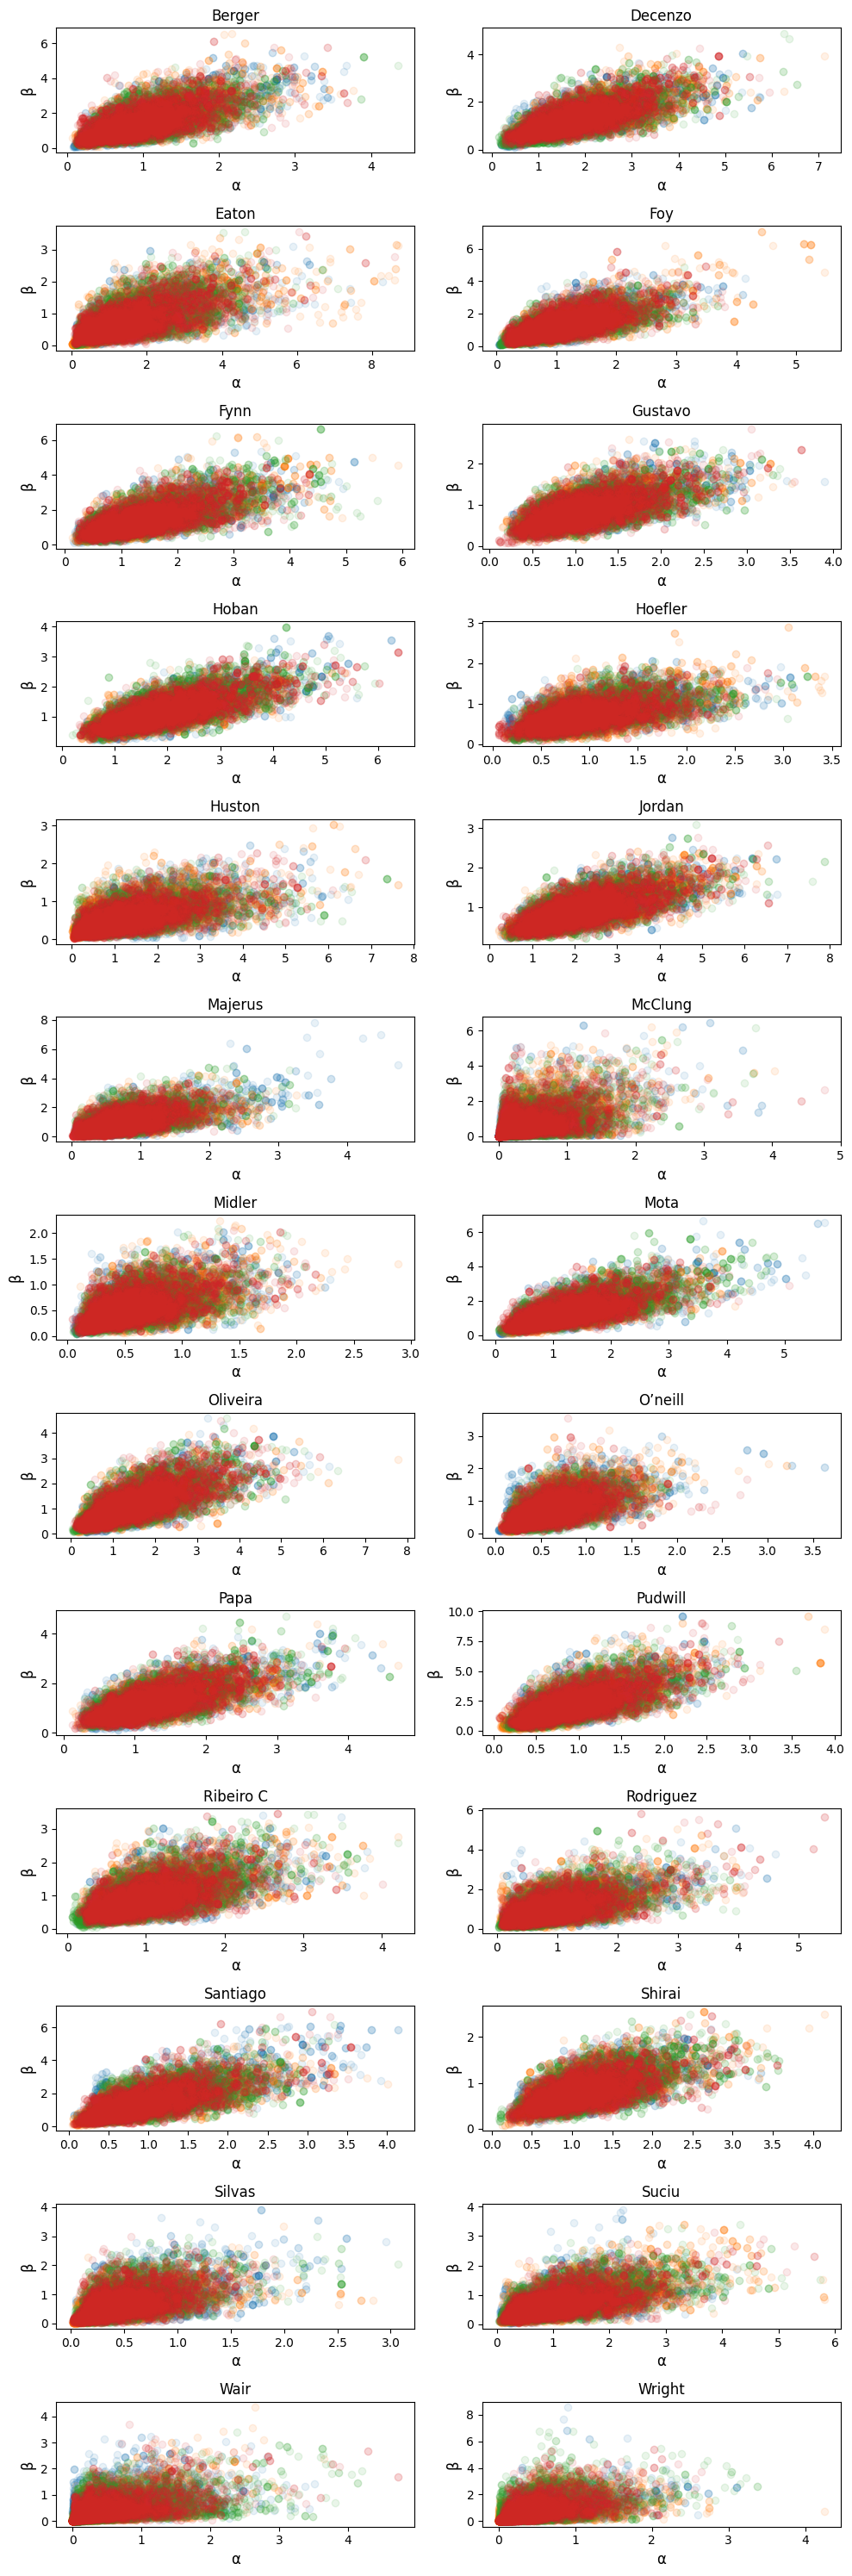

In [20]:
rows = len(run_samples_dict) // 2
fig, axs = plt.subplots(rows, 2, figsize=(10, 30))

# hist of theta, heatmap of alpha and beta
# ignore first 1000 samples
for i, (name, samples) in enumerate(run_samples_dict.items()):
    row = i // 2
    col = i % 2
    alpha_tricks, beta_tricks = [[sample[1000:, i] for sample in samples] for i in range(2)]

    for i in range(n_chains):
        axs[row, col].plot(alpha_tricks[i], beta_tricks[i], 'o', alpha=0.1)
        axs[row, col].set_title(f"{name}")
        axs[row, col].set_xlabel('α', fontsize='large')
        axs[row, col].set_ylabel('β', fontsize='large')
    
plt.tight_layout()

In [33]:
bayes_samples = {}
for name, trick_samples in trick_samples_dict.items():
    run_samples = run_samples_dict[name]
    bayes_samples[name] = [np.concatenate([trick_samples[i][1000:], run_samples[i][1000:]], axis=1) for i in range(n_chains)]

In [34]:
# make df of sample mean and variance for each parameter for each skater. only want to look at samples after burn-in
bayesian_params = pd.DataFrame(
    columns=['theta_mean', 'theta_var', 'alpha_trick_mean', 'alpha_trick_var', 'beta_trick_mean', 'beta_trick_var', 'alpha_run_mean', 'alpha_run_var', 'beta_run_mean', 'beta_run_var']
)
for name, samples in bayes_samples.items():
    thetas, alpha_tricks, beta_tricks, alpha_runs, beta_runs = [np.concatenate([sample[:, i] for sample in samples], axis=0) for i in range(5)]
    bayesian_params.loc[name] = [thetas.mean(), thetas.var(), alpha_tricks.mean(), alpha_tricks.var(), beta_tricks.mean(), beta_tricks.var(), alpha_runs.mean(), alpha_runs.var(), beta_runs.mean(), beta_runs.var()]
print(bayesian_params)

AttributeError: 'list' object has no attribute 'mean'

(d) Använd din bayesiansk modell för [Xi,Yi]T för att simulera 5000 LCQ:ar genom att ta utfall från de lämpliga de aposteriori prediktiva fördelningarna. Vad är typvärdet av dina utfall W1,...,W5000? Hur många av de riktiga vinnarna förutsägs? Vad är den skattade sannolikheten för de riktiga vinnarna baserat på dina utfall? Av typvärdet?

In [30]:
results = []
for _ in range(5000):
    row_scores = {}
    for _, row in bayesian_params.iterrows():
        score = 0
        
        # runs
        alpha_tricks, beta_tricks = row[f'alpha_run_mean'], row[f'beta_run_mean']
        for _ in range(1, 3):
            score += np.random.beta(alpha_tricks, beta_tricks)
        
        # tricks
        alpha_tricks, beta_tricks = row[f'alpha_trick_mean'], row[f'beta_trick_mean']
        for _ in range(1, 5):
            if np.random.uniform() < row['theta_mean']:
                score += np.random.beta(alpha_tricks, beta_tricks)
        row_scores[row.name] = score
    results.append(row_scores)
bayes_scores_df = pd.DataFrame(results)

In [31]:
bayes_total_scores = bayes_scores_df.sum(axis=0)
bayes_total_scores.sort_values(ascending=False, inplace=True)
print('Highest total scores')
print(bayes_total_scores[0:4])

bayes_top_4 = bayes_scores_df.apply(lambda row: row.nlargest(4).index.tolist(), axis=1)
bayes_top_4 = [item for sublist in bayes_top_4 for item in sublist]
bayes_top_4 = pd.Series(bayes_top_4).value_counts()
print('\nMost frequent top 4')
print(bayes_top_4[0:4])

print('\nProbability that winners won')
winners = ['Gustavo', 'Hoban', 'Eaton', 'Decenzo']
for winner in winners:
    print(f"{winner}: {bayes_top_4[winner] / len(bayes_scores_df)}")

Highest total scores
Eaton     14524.880372
Suciu     13963.807020
Jordan    13123.511191
Hoban     12441.286314
dtype: float64

Most frequent top 4
Eaton     2170
Suciu     1917
Jordan    1497
Hoban     1258
Name: count, dtype: int64

Probability that winners won
Gustavo: 0.1844
Hoban: 0.2516
Eaton: 0.434
Decenzo: 0.2312


# 4. En bayesiansk modell med en hierarki. 
##### För att ta hänsyn till möjliga variationer i skateboardåkarnas prestationer mellan olika tävlingar kan vi bygga en modell som använda en hierarki. Som vi såg i föreläsningarna kan vi bygga en bayesiansk hierarki för Vi ∼ Ber(θi) om vi grupperar utfall vi enligt de olika tävlingarna. För enkelhets skull använder vi våra frekventisktiska punktskattningar för parametrarna αi,βi och parametrarna för Yi från uppgift 2.

(a) Anta att Θi|Ai = αi,Bi = βi ∼ Beta(αi,βi) och välj en lämplig simultan apriorifördelning för [Θi, Ai, Bi]T . Motivera ditt val.